In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np
import os
import random
from torchvision import transforms
from PIL import Image
from torch.utils.data import random_split
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt


# Below are my classes:
**VideoTransform** - Does data augmentation on video data

**VideoDataset** - Modifies & formats video frames before they are input into the CNN

**AudioDataset** - Interprets & formats audio data before its sent into the MLP NN

**AudioMLP** - Defines MLP NN

**Early Stopping**

In [5]:
class VideoTransform:
    def __init__(self, is_train=True):
        if is_train:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(10),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                transforms.Resize((112, 112)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((112, 112)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ])

    def __call__(self, frames):
        return torch.stack([self.transform(frame) for frame in frames])


class VideoDataset(Dataset):
    def __init__(self, video_path, transform=None, clip_length=16, frame_size=(112, 112), return_filename=False, random_clip=True):
        self.video_path = video_path
        self.transform = transform
        self.clip_length = clip_length
        self.frame_size = frame_size
        self.return_filename = return_filename
        self.random_clip = random_clip
        self.video_files = [f for f in os.listdir(video_path) if f.endswith('.mp4')]

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_file = self.video_files[idx]
        video = cv2.VideoCapture(os.path.join(self.video_path, video_file))

        frames = []
        while video.isOpened():
            ret, frame = video.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, self.frame_size)
            frames.append(frame)
        video.release()

        frames = np.array(frames)

        if len(frames) >= self.clip_length:
            if self.random_clip:
                start_frame = np.random.randint(0, len(frames) - self.clip_length)
            else:
                start_frame = 0
            frames = frames[start_frame:start_frame + self.clip_length]
        else:
            frames += [frames[-1]] * (self.clip_length - len(frames))
            
        if self.transform:
            frames = self.transform(frames)  

        label = 0 if 'lie' in video_file.lower() else 1

        if self.return_filename:
            return frames, label, video_file
        else:
            return frames, label

In [6]:
class AudioDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file, index_col=0)  
        self.feature_columns = [col for col in self.data.columns if col != 'id' and self.data[col].dtype in [np.float32, np.float64, np.int64, np.int32]]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        features = row[self.feature_columns].astype(np.float32).values
        label = 0 if 'lie' in row['id'].lower() else 1

        #if idx == 0:
            #print(f"[Debug] Sample ID: {row['id']}")
            #print(f"[Debug] Features: {features}")
            #print(f"[Debug] Label: {label}")

        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)




class AudioMLP(nn.Module):
    def __init__(self, input_size):
        super(AudioMLP, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.classifier = nn.Linear(32, 2)

    def forward(self, x, return_features=False):
        features = self.feature_extractor(x)
        if return_features:
            return features
        return self.classifier(features)
    def extract_features(self, x):
        with torch.no_grad():
            return self.feature_extractor(x)

In [7]:
class EarlyStopping:
    def __init__(self, patience=3, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.best_loss = float('inf')
        self.counter = 0 
        self.stop_training = False 

    def __call__(self, epoch_loss):
        if epoch_loss < self.best_loss:
            self.best_loss = epoch_loss
            self.counter = 0
            if self.verbose:
                print(f"Epoch improved with loss {epoch_loss:.4f}. Saving model.")
            return False
        
        self.counter += 1
        if self.counter >= self.patience:
            if self.verbose:
                print(f"Early stopping triggered after {self.counter} epochs without improvement.")
            self.stop_training = True
        return self.stop_training


# Audio Training

In [8]:
audio_dataset = AudioDataset('/kaggle/input/deception-detection-dataset/audiodata.csv')
input_dim = audio_dataset[0][0].shape[0]  

train_size = int(0.8 * len(audio_dataset))
val_size = len(audio_dataset) - train_size
train_set, val_set = random_split(audio_dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
audio_model = AudioMLP(input_size=input_dim).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(audio_model.parameters(), lr=1e-3)

In [9]:
num_epochs = 50
early_stopping = EarlyStopping(patience=5, verbose=True)

for epoch in range(num_epochs):
    audio_model.train()
    total_loss, correct, total = 0, 0, 0

    print(f"\n--- Epoch {epoch + 1} ---")
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = audio_model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    print(f"[Epoch {epoch + 1}] Train Loss: {total_loss:.4f} | Accuracy: {train_acc:.4f}")

    audio_model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = audio_model(features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    print(f"[Epoch {epoch + 1}] Val Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}")

    if val_loss < early_stopping.best_loss:
        torch.save(audio_model.state_dict(), 'best_audio_model.pth')
    if early_stopping(val_loss):
        print(f"Stopping early at epoch {epoch + 1}")
        break



--- Epoch 1 ---
[Epoch 1] Train Loss: 9.1360 | Accuracy: 0.5312
[Epoch 1] Val Loss: 0.8452 | Accuracy: 0.8800
Epoch improved with loss 0.8452. Saving model.

--- Epoch 2 ---
[Epoch 2] Train Loss: 9.8784 | Accuracy: 0.5208
[Epoch 2] Val Loss: 0.8769 | Accuracy: 0.8000

--- Epoch 3 ---
[Epoch 3] Train Loss: 10.2364 | Accuracy: 0.3958
[Epoch 3] Val Loss: 1.0302 | Accuracy: 0.7200

--- Epoch 4 ---
[Epoch 4] Train Loss: 7.0148 | Accuracy: 0.5208
[Epoch 4] Val Loss: 0.9358 | Accuracy: 0.7600

--- Epoch 5 ---
[Epoch 5] Train Loss: 6.9291 | Accuracy: 0.5000
[Epoch 5] Val Loss: 1.0780 | Accuracy: 0.7200

--- Epoch 6 ---
[Epoch 6] Train Loss: 6.6739 | Accuracy: 0.5417
[Epoch 6] Val Loss: 0.9468 | Accuracy: 0.8000
Early stopping triggered after 5 epochs without improvement.
Stopping early at epoch 6


/tmp/ipykernel_31/4006021330.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  audio_model.load_state_dict(torch.load('/kaggle/input/460j-best-models/other/default/1/best

ID: lie1.mp4, Predicted: 0, Actual: 0
ID: lie2.mp4, Predicted: 0, Actual: 0
ID: lie3.mp4, Predicted: 0, Actual: 0
ID: lie4.mp4, Predicted: 0, Actual: 0
ID: lie5.mp4, Predicted: 0, Actual: 0
ID: lie6.mp4, Predicted: 0, Actual: 0
ID: lie7.mp4, Predicted: 0, Actual: 0
ID: lie8.mp4, Predicted: 0, Actual: 0
ID: lie9.mp4, Predicted: 1, Actual: 0
ID: lie10.mp4, Predicted: 0, Actual: 0
ID: lie11.mp4, Predicted: 1, Actual: 0
ID: lie12.mp4, Predicted: 1, Actual: 0
ID: lie13.mp4, Predicted: 1, Actual: 0
ID: lie14.mp4, Predicted: 0, Actual: 0
ID: lie15.mp4, Predicted: 0, Actual: 0
ID: truth1.mp4, Predicted: 0, Actual: 1
ID: truth2.mp4, Predicted: 1, Actual: 1
ID: truth3.mp4, Predicted: 0, Actual: 1
ID: truth4.mp4, Predicted: 1, Actual: 1
ID: truth5.mp4, Predicted: 0, Actual: 1
ID: truth6.mp4, Predicted: 0, Actual: 1
ID: truth7.mp4, Predicted: 0, Actual: 1
ID: truth8.mp4, Predicted: 0, Actual: 1
ID: truth9.mp4, Predicted: 0, Actual: 1
ID: truth10.mp4, Predicted: 0, Actual: 1
ID: truth11.mp4, Predic

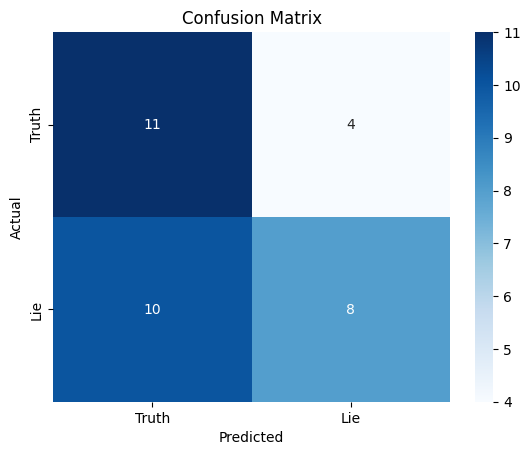


Classification Report:
              precision    recall  f1-score   support

       Truth       0.52      0.73      0.61        15
         Lie       0.67      0.44      0.53        18

    accuracy                           0.58        33
   macro avg       0.60      0.59      0.57        33
weighted avg       0.60      0.58      0.57        33

AUC: 0.5741


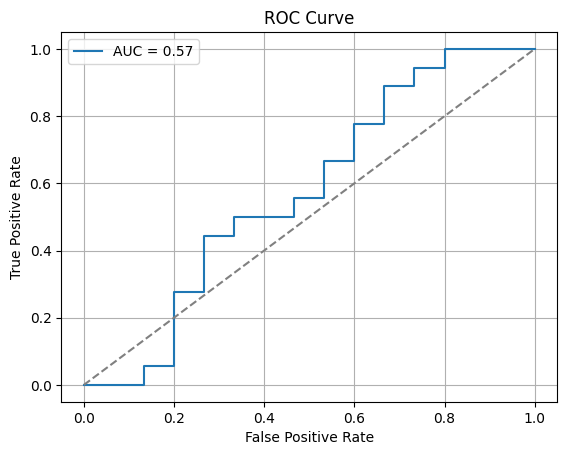

In [10]:
import torch
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

test_audio_csv = "/kaggle/input/deception-detection-dataset/testaudiodata.csv"
audio_df = pd.read_csv(test_audio_csv, index_col=0)
audio_df['id'] = audio_df['id'].astype(str)

test_audio_dataset = AudioDataset(test_audio_csv)
test_loader = DataLoader(test_audio_dataset, batch_size=16, shuffle=False)

audio_model.load_state_dict(torch.load('/kaggle/input/460j-best-models/other/default/1/best_audio_model.pth'))
audio_model.to(device)
audio_model.eval()

all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for batch_idx, (features, labels) in enumerate(test_loader):
        features, labels = features.to(device), labels.to(device)
        outputs = audio_model(features)

        probs = torch.softmax(outputs, dim=1)[:, 1]  
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        start_idx = batch_idx * 16
        for i in range(len(preds)):
            global_idx = start_idx + i
            sample_id = audio_df.iloc[global_idx]['id']
            print(f"ID: {sample_id}, Predicted: {preds[i].item()}, Actual: {labels[i].item()}")

accuracy = sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
print(f"[Audio-Only] Test Accuracy: {accuracy:.4f}")

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Truth', 'Lie'], yticklabels=['Truth', 'Lie'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Truth", "Lie"]))

try:
    auc = roc_auc_score(all_labels, all_probs)
    print(f"AUC: {auc:.4f}")

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()
except ValueError as e:
    print(f"Could not compute AUC: {e}")

# Video Frame Training

In [11]:
train_transform = VideoTransform(is_train=True)
val_transform = VideoTransform(is_train=False)
test_transform = VideoTransform(is_train=False)

video_path_train_deceptive = '/kaggle/input/deception-detection-dataset/Real-life_Deception_Detection_2016/Clips/Deceptive'
video_path_train_truthful = '/kaggle/input/deception-detection-dataset/Real-life_Deception_Detection_2016/Clips/Truthful'
deceptive_train_dataset = VideoDataset(video_path_train_deceptive, transform=train_transform)
truthful_train_dataset = VideoDataset(video_path_train_truthful, transform=train_transform)

combined_train_dataset = torch.utils.data.ConcatDataset([deceptive_train_dataset, truthful_train_dataset])
combined_test_dataset = VideoDataset('/kaggle/input/deception-detection-dataset/testset/Clips', transform=test_transform, return_filename=True, random_clip=False)

train_size = int(0.8 * len(combined_train_dataset))
val_size = len(combined_train_dataset) - train_size
train_dataset, val_dataset= random_split(combined_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(combined_test_dataset, batch_size=16, shuffle=False, num_workers=2)

In [12]:
learning_rate = 1e-5 
batch_size = 16      
num_epochs = 2       
weight_decay = 1e-4  
scheduler_step_size = 5 
scheduler_gamma = 0.1    

video_model = torchvision.models.video.r3d_18(pretrained=True)

for name, param in video_model.named_parameters():
    if  "layer4" in name or "fc" in name: 
        param.requires_grad = True
    else: 
        param.requires_grad = False

video_model.fc = nn.Linear(in_features=512, out_features=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
video_model = video_model.to(device)

criterion = nn.CrossEntropyLoss()
early_stopping = EarlyStopping(patience=3, verbose=True)
optimizer = optim.Adam([
    {'params': video_model.layer3.parameters(), 'lr': 1e-5},
    {'params': video_model.layer4.parameters(), 'lr': 1e-5},
    {'params': video_model.fc.parameters(), 'lr': 1e-4}
], weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /root/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [00:00<00:00, 217MB/s] 


In [48]:
for epoch in range(num_epochs):
    video_model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = video_model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct_preds += torch.sum(preds == labels)
        total_preds += labels.size(0)

    scheduler.step()
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_preds.double() / total_preds
    print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")

    video_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(device).permute(0, 2, 1, 3, 4)
            val_labels = val_labels.to(device)

            val_outputs = video_model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item()

            _, val_preds = torch.max(val_outputs, 1)
            val_correct += torch.sum(val_preds == val_labels)
            val_total += val_labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = val_correct.double() / val_total
    print(f"[Epoch {epoch+1}] Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")

    if early_stopping(val_loss):
        print("Stopping early due to no improvement in validation loss.")
        break

    if val_loss == early_stopping.best_loss:
        torch.save(video_model.state_dict(), 'best_video_model.pth')


[Epoch 1] Train Loss: 0.6740 | Train Accuracy: 0.6250
[Epoch 1] Val Loss: 0.6478 | Val Accuracy: 0.5600
Epoch improved with loss 0.6478. Saving model.
[Epoch 2] Train Loss: 0.6205 | Train Accuracy: 0.6354
[Epoch 2] Val Loss: 0.5822 | Val Accuracy: 0.6800
Epoch improved with loss 0.5822. Saving model.


/tmp/ipykernel_31/656256331.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  video_model.load_state_dict(torch.load('/kaggle/input/460j-best-models/other/default/1/best_v

[Video-Only] Test Loss: 0.6365, Test Accuracy: 0.6970
ID: lie7.mp4, Predicted: 1, Actual: 0
ID: lie5.mp4, Predicted: 0, Actual: 0
ID: truth1.mp4, Predicted: 1, Actual: 1
ID: truth6.mp4, Predicted: 1, Actual: 1
ID: truth15.mp4, Predicted: 1, Actual: 1
ID: truth7.mp4, Predicted: 1, Actual: 1
ID: truth9.mp4, Predicted: 1, Actual: 1
ID: truth13.mp4, Predicted: 1, Actual: 1
ID: truth5.mp4, Predicted: 1, Actual: 1
ID: lie9.mp4, Predicted: 1, Actual: 0
ID: lie13.mp4, Predicted: 0, Actual: 0
ID: lie10.mp4, Predicted: 1, Actual: 0
ID: lie2.mp4, Predicted: 0, Actual: 0
ID: lie12.mp4, Predicted: 1, Actual: 0
ID: lie3.mp4, Predicted: 1, Actual: 0
ID: truth16.mp4, Predicted: 1, Actual: 1
ID: truth4.mp4, Predicted: 1, Actual: 1
ID: truth11.mp4, Predicted: 1, Actual: 1
ID: truth12.mp4, Predicted: 1, Actual: 1
ID: lie14.mp4, Predicted: 0, Actual: 0
ID: lie4.mp4, Predicted: 0, Actual: 0
ID: lie1.mp4, Predicted: 1, Actual: 0
ID: truth17.mp4, Predicted: 1, Actual: 1
ID: lie6.mp4, Predicted: 1, Actual: 0


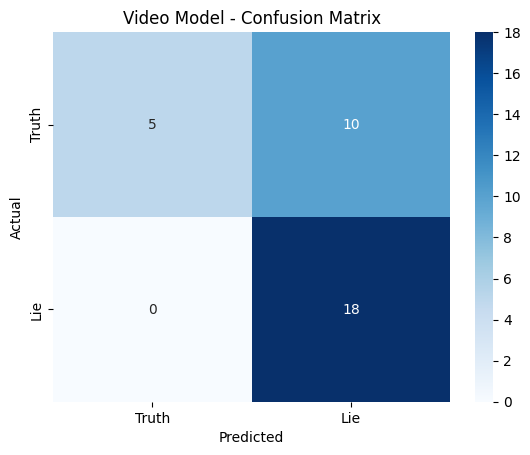


Classification Report:
              precision    recall  f1-score   support

       Truth       1.00      0.33      0.50        15
         Lie       0.64      1.00      0.78        18

    accuracy                           0.70        33
   macro avg       0.82      0.67      0.64        33
weighted avg       0.81      0.70      0.65        33

AUC: 0.7222


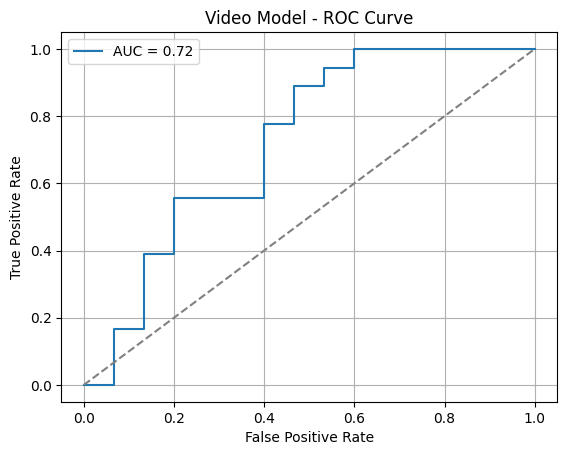

In [14]:
video_model.load_state_dict(torch.load('/kaggle/input/460j-best-models/other/default/1/best_video_model.pth'))
video_model.to(device)
video_model.eval()

test_correct_preds = 0
test_total_preds = 0
test_loss = 0.0
all_preds = []
all_probs = []
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels, filenames in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        inputs = inputs.permute(0, 2, 1, 3, 4)  # B, C, T, H, W
        outputs = video_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        probs = torch.softmax(outputs, dim=1)[:, 1]  # Probabilities for class 1
        preds = torch.argmax(outputs, dim=1)

        test_correct_preds += (preds == labels).sum().item()
        test_total_preds += labels.size(0)

        for i in range(len(preds)):
            sample_id = filenames[i]
            predicted_label = preds[i].item()
            actual_label = labels[i].item()
            probability = probs[i].item()
            all_predictions.append((sample_id, predicted_label, actual_label))
            all_preds.append(predicted_label)
            all_probs.append(probability)
            all_labels.append(actual_label)

test_accuracy = test_correct_preds / test_total_preds
test_loss = test_loss / len(test_loader)

print(f"[Video-Only] Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

for prediction in all_predictions:
    print(f"ID: {prediction[0]}, Predicted: {prediction[1]}, Actual: {prediction[2]}")

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Truth', 'Lie'], yticklabels=['Truth', 'Lie'])
plt.title('Video Model - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Truth", "Lie"]))

try:
    auc = roc_auc_score(all_labels, all_probs)
    print(f"AUC: {auc:.4f}")

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Video Model - ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()
except ValueError as e:
    print(f"Could not compute AUC: {e}")

# Hybrid Model

In [19]:
#saved_state_dict = torch.load('best_audio_model.pth')
#print(saved_state_dict.keys())

#video_model.load_state_dict(torch.load('best_video_model.pth'))  # Load video model weights
#video_model = video_model.to(device)

audio_model = AudioMLP(input_size=12)
#audio_model.load_state_dict(torch.load('best_audio_model.pth'))  # Load audio model weights
#audio_model = audio_model.to(device)

#video_model.eval()
#audio_model.eval()

def extract_video_features(model, x):
    x = model.stem(x)
    x = model.layer1(x)
    x = model.layer2(x)
    x = model.layer3(x)
    x = model.layer4(x)
    x = model.avgpool(x)  
    x = x.view(x.size(0), -1)  
    return x

class FusionClassifier(nn.Module):
    def __init__(self, video_dim=512, audio_dim=32, hidden_dim=128):
        super(FusionClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(video_dim + audio_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, video_feat, audio_feat):
        fused = torch.cat((video_feat, audio_feat), dim=1)
        return self.classifier(fused)
        
class MultiModalDataset(Dataset):
    def __init__(self, video_dataset, audio_df):
        self.video_dataset = video_dataset
        self.audio_df = audio_df.set_index('id')
        self.feature_cols = [col for col in self.audio_df.columns if col not in ['id'] and self.audio_df[col].dtype in [float, int]]

    def __len__(self):
        return len(self.video_dataset)

    def __getitem__(self, idx):
        video_tensor, label, filename = self.video_dataset[idx]
        base_id = os.path.splitext(filename)[0]
        audio_row = self.audio_df[self.audio_df.index.str.contains(base_id, case=False, na=False)].iloc[0]
        audio_feat = torch.tensor(audio_row[self.feature_cols].values, dtype=torch.float32)
        return video_tensor, audio_feat, label

audio_df = pd.read_csv('/kaggle/input/deception-detection-dataset/audiodata.csv', index_col=0)
audio_df['id'] = audio_df['id'].astype(str)

deceptive_train_dataset = VideoDataset(video_path_train_deceptive, transform=train_transform, return_filename=True)
truthful_train_dataset = VideoDataset(video_path_train_truthful, transform=train_transform, return_filename=True)
combined_train_dataset = torch.utils.data.ConcatDataset([deceptive_train_dataset, truthful_train_dataset])
train_size = int(0.9 * len(combined_train_dataset))
val_size = len(combined_train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(combined_train_dataset, [train_size, val_size])

fusion_train_dataset = MultiModalDataset(train_dataset, audio_df)
fusion_val_dataset = MultiModalDataset(val_dataset, audio_df)

fusion_train_loader = DataLoader(fusion_train_dataset, batch_size=8, shuffle=True, num_workers=2)
fusion_val_loader = DataLoader(fusion_val_dataset, batch_size=8, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fusion_model = FusionClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fusion_model.parameters(), lr=1e-4)

num_epochs = 1
best_val_loss = float('inf') 
counter = 0
patience = 3 

In [68]:
for epoch in range(num_epochs):
    fusion_model.train()
    total_loss, correct, total = 0, 0, 0

    for video_input, audio_input, labels in fusion_train_loader:
        video_input = video_input.to(device).permute(0, 2, 1, 3, 4)
        audio_input = audio_input.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            video_features = extract_video_features(video_model, video_input)
            audio_features = audio_model.extract_features(audio_input)

            if epoch == 0 and total == 0:
                print("=== Debug: Video Features ===")
                print(video_features[0][:10].cpu().numpy())  
                print("Mean:", video_features.mean().item(), "Std:", video_features.std().item())
                print("=== Debug: Audio Features ===")
                print(audio_features[0][:10].cpu().numpy())  
                print("Mean:", audio_features.mean().item(), "Std:", audio_features.std().item())
                print("=== Debug: Fusion Output (Softmax Probs) ===")
                probs = torch.softmax(outputs, dim=1)
                print(probs[0].cpu().numpy()) 

        outputs = fusion_model(video_features, audio_features)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = total_loss / len(fusion_train_loader)
    train_accuracy = correct / total
    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")

    fusion_model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for video_input, audio_input, labels in fusion_val_loader:
            video_input = video_input.to(device).permute(0, 2, 1, 3, 4)
            audio_input = audio_input.to(device)
            labels = labels.to(device)

            video_features = extract_video_features(video_model, video_input)
            audio_features = audio_model(audio_input, return_features=True)

            outputs = fusion_model(video_features, audio_features)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(fusion_val_loader)
    val_accuracy = val_correct / val_total
    print(f"[Epoch {epoch+1}] Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}")

    if avg_val_loss < best_val_loss:
        print(f"Validation loss improved! Saving model...")
        best_val_loss = avg_val_loss
        torch.save(fusion_model.state_dict(), 'best_fusion_model.pth')
        counter = 0  
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered. No improvement for {patience} epochs.")
            break 

print("Training complete. Evaluating on validation set.")
fusion_model.load_state_dict(torch.load('best_fusion_model.pth'))

fusion_model.eval()
correct, total = 0, 0
with torch.no_grad():
    for video_input, audio_input, labels in fusion_val_loader:
        video_input = video_input.to(device).permute(0, 2, 1, 3, 4)
        audio_input = audio_input.to(device)
        labels = labels.to(device)

        video_features = extract_video_features(video_model, video_input)
        audio_features = audio_model(audio_input, return_features=True)

        outputs = fusion_model(video_features, audio_features)
        preds = outputs.argmax(dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Final Fusion Validation Accuracy: {correct / total:.4f}")

odict_keys(['feature_extractor.0.weight', 'feature_extractor.0.bias', 'feature_extractor.3.weight', 'feature_extractor.3.bias', 'classifier.weight', 'classifier.bias'])


/tmp/ipykernel_31/1551998654.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_state_dict = torch.load('best_audio_model.pth')
/tmp/ipykernel_31/1551998654.py:9: Fut

=== Debug: Video Features ===
[1.1223357  0.7284938  0.3567763  1.3257549  0.49060774 0.3988218
 0.58889437 1.6691843  0.56360155 1.7661355 ]
Mean: 0.6625611782073975 Std: 0.5183040499687195
=== Debug: Audio Features ===
[18.913456  7.541112  0.        0.        0.       18.87668   0.
  0.       10.212227  0.      ]
Mean: 6.618181228637695 Std: 10.151458740234375
=== Debug: Fusion Output (Softmax Probs) ===
[0.30430704 0.6956929 ]
[Epoch 1] Train Loss: 0.8234 | Train Accuracy: 0.4907
[Epoch 1] Validation Loss: 0.6804 | Validation Accuracy: 0.5385
Validation loss improved! Saving model...
Training complete. Evaluating on validation set.


/tmp/ipykernel_31/1551998654.py:161: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fusion_model.load_state_dict(torch.load('best_fusion_model.pth'))


Final Fusion Validation Accuracy: 0.6154


In [20]:
class TestDataset(Dataset):
    def __init__(self, video_dataset, audio_df, transform=None):
        self.video_dataset = video_dataset 
        self.audio_df = audio_df 
        self.audio_df['id'] = self.audio_df['id'].astype(str)  
        self.feature_columns = [col for col in self.audio_df.columns if col != 'id'] 
        self.transform = transform 

    def __len__(self):
        return len(self.video_dataset)

    def __getitem__(self, idx):
        video_input, video_label, video_filename = self.video_dataset[idx]
        base_id = os.path.splitext(video_filename)[0]

        matching_audio_row = self.audio_df[self.audio_df['id'].str.contains(base_id, case=False, na=False)]
        if matching_audio_row.empty:
            audio_feat = torch.zeros(len(self.feature_columns), dtype=torch.float32)
        else:
            audio_feat = torch.tensor(matching_audio_row[self.feature_columns].values[0], dtype=torch.float32)

        if self.transform:
            video_input = self.transform(video_input)

        return video_input, audio_feat, video_label, video_filename


/tmp/ipykernel_31/4070884050.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fusion_model.load_state_dict(torch.load('/kaggle/input/460j-best-models/other/default/1/best

File: lie7.mp4, Predicted: 1, Actual: 0
File: lie5.mp4, Predicted: 1, Actual: 0
File: truth1.mp4, Predicted: 1, Actual: 1
File: truth6.mp4, Predicted: 1, Actual: 1
File: truth15.mp4, Predicted: 1, Actual: 1
File: truth7.mp4, Predicted: 1, Actual: 1
File: truth9.mp4, Predicted: 1, Actual: 1
File: truth13.mp4, Predicted: 1, Actual: 1
File: truth5.mp4, Predicted: 1, Actual: 1
File: lie9.mp4, Predicted: 1, Actual: 0
File: lie13.mp4, Predicted: 1, Actual: 0
File: lie10.mp4, Predicted: 1, Actual: 0
File: lie2.mp4, Predicted: 1, Actual: 0
File: lie12.mp4, Predicted: 1, Actual: 0
File: lie3.mp4, Predicted: 1, Actual: 0
File: truth16.mp4, Predicted: 1, Actual: 1
File: truth4.mp4, Predicted: 1, Actual: 1
File: truth11.mp4, Predicted: 1, Actual: 1
File: truth12.mp4, Predicted: 1, Actual: 1
File: lie14.mp4, Predicted: 0, Actual: 0
File: lie4.mp4, Predicted: 1, Actual: 0
File: lie1.mp4, Predicted: 0, Actual: 0
File: truth17.mp4, Predicted: 1, Actual: 1
File: lie6.mp4, Predicted: 1, Actual: 0
File: 

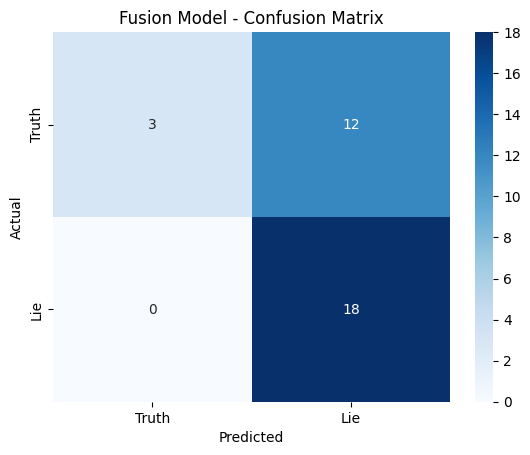


Classification Report:
              precision    recall  f1-score   support

       Truth       1.00      0.20      0.33        15
         Lie       0.60      1.00      0.75        18

    accuracy                           0.64        33
   macro avg       0.80      0.60      0.54        33
weighted avg       0.78      0.64      0.56        33

AUC: 0.5481


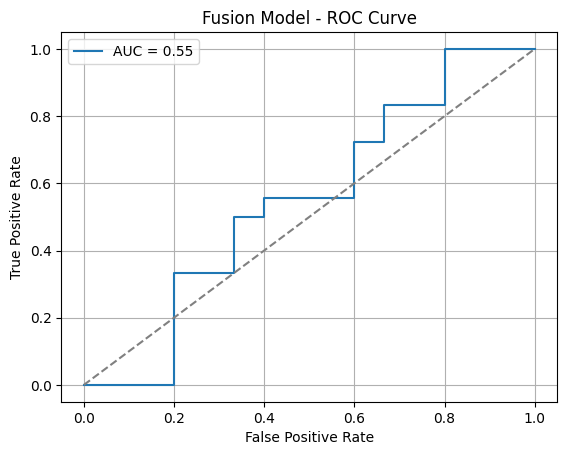

In [34]:
fusion_model.load_state_dict(torch.load('/kaggle/input/460j-best-models/other/default/1/best_fusion_model.pth'))
video_model.load_state_dict(torch.load('/kaggle/input/460j-best-models/other/default/1/best_video_model.pth'))
audio_model.load_state_dict(torch.load('/kaggle/input/460j-best-models/other/default/1/best_audio_model.pth'))

fusion_model.eval()
video_model.eval()
audio_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fusion_model.to(device)
video_model.to(device)
audio_model.to(device)

test_audio_csv = "/kaggle/input/deception-detection-dataset/testaudiodata.csv"
audio_df = pd.read_csv(test_audio_csv, index_col=0)
audio_df['id'] = audio_df['id'].astype(str)

feature_cols = [col for col in audio_df.columns if col not in ['label', 'id']]
feature_means = audio_df[feature_cols].mean()
feature_stds = audio_df[feature_cols].std().replace(0, 1)
audio_df[feature_cols] = (audio_df[feature_cols] - feature_means) / feature_stds

combined_test_dataset = VideoDataset(
    '/kaggle/input/deception-detection-dataset/testset/Clips',
    transform=test_transform,
    return_filename=True,
    random_clip=False
)
test_dataset = TestDataset(combined_test_dataset, audio_df, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

criterion = nn.CrossEntropyLoss()
correct, total = 0, 0
test_loss = 0.0
all_preds, all_probs, all_labels, all_filenames = [], [], [], []

with torch.no_grad():
    for video_input, audio_input, labels, filenames in test_loader:
        video_input = video_input.to(device).permute(0, 2, 1, 3, 4)
        audio_input = audio_input.to(device)
        labels = labels.to(device)

        video_features = extract_video_features(video_model, video_input)
        audio_features = audio_model(audio_input, return_features=True)

        fusion_logits = fusion_model(video_features, audio_features)
        loss = criterion(fusion_logits, labels)
        test_loss += loss.item()

        fusion_probs = torch.softmax(fusion_logits, dim=1)

        audio_logits = audio_model(audio_input)
        audio_probs = torch.softmax(audio_logits, dim=1)

        final_probs = 0.5 * fusion_probs + 0.5 * audio_probs

        probs = final_probs[:, 1] 
        predicted = torch.argmax(final_probs, dim=1)


        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_filenames.extend(filenames)

for fname, pred, true in zip(all_filenames, all_preds, all_labels):
    print(f"File: {fname}, Predicted: {pred}, Actual: {true}")

accuracy = 100 * correct / total
avg_test_loss = test_loss / len(test_loader)

print(f"\n[Fusion Model] Test Accuracy: {accuracy:.2f}%")
print(f"Test Loss: {avg_test_loss:.4f}")

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Truth', 'Lie'], yticklabels=['Truth', 'Lie'])
plt.title('Fusion Model - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Truth', 'Lie']))

try:
    auc = roc_auc_score(all_labels, all_probs)
    print(f"AUC: {auc:.4f}")

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Fusion Model - ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()
except ValueError as e:
    print(f"Could not compute AUC: {e}")